# ECON 31200 Part B Problem Set 3
#### Chase Abram, Tom Hierons, Jeanne Sorin


## Preliminary

In [13]:
### IMPORT PACKAGES
import numpy as np

import scipy.stats as st
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import binom

import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.integrate import simps

## Defining Functions

### The DGP

In [14]:
### FUNCTIONS FOR THE DGP

def cov_f(conf=[1, 1, 1, 0, 0,0]):
    '''
    Function creating the covariance matrix for the different configurations
    Takes as default the identity matrix
    '''
    cov = [[conf[1], conf[3], conf[4]],
          [conf[3], conf[0], conf[5]],
          [conf[4], conf[5], conf[2]]]
    return(cov)

def errors_f(mean, cov, N):
    ''' This function generates multivariate join normal errors U1, U0, UC '''
    U1, U0, UC = np.random.multivariate_normal(mean, cov, N).T
    return(U1, U0, UC)

def Z_f(min, max, N):
    ''' This function generates Z ~ Unif[min, max] '''
    return(np.random.uniform(min, max, N))

def Y1_f(α, β, U1):
    ''' This function computes Y1 for a given vector U1 '''
    return(α + β + U1)

def Y0_f(α, U0):
    ''' This function computes Y0 for a given vector U0 '''
    return(α + U0)

def C_f(Z, UC):
    ''' This function computes C for given vectors Z and UC (independent)'''
    return(Z + UC)

def D_f(Y1, Y0, C):
    ''' This function computes the choice function D, given vectors Y1, Y0 and C '''
    D = np.zeros(len(Y0))
    for i in range(len(Y0)):
        if Y1[i] - Y0[i] - C[i] >= 0: 
            D[i] = 1
    return(D)

def muD_f(β, Z):
    ''' This function computes μD(Z) '''
    return(β + Z)
    


### A function to generate data in one clic

In [15]:
def DGP_f(N, α, β, min, max, mean, conf, minmax2=False, min2 = 0, max2 = 0):
    ''' This function generates the data "in one clic" '''
    
    cov = cov_f(conf)
    U1, U0, UC = errors_f(mean, cov, N)
    Y1 = Y1_f(α, β, U1)
    Y0 = Y0_f(α, U0)
    
    if minmax2 == False:
        Z = Z_f(min, max, N)
    if minmax2 == True:
        '''
        Relevant for 3.C. 
        Bonus: allow interval to have different lenght because why not'''
        Z1 = Z_f(min, max, N)
        Z2 = Z_f(min2, max2, N)
        p = (max - min)/(max - min + max2 - min2)
        pick = binom.rvs(1, 0.5, size=N)
        Z = Z1*pick + Z2*(1-pick)
 
    C = C_f(Z, UC)
    D = D_f(Y1, Y0, C)
    μD = muD_f(β, Z)
    return(Y1, Y0, Z, C, D, cov, μD, U1, U0, UC)

### The Econometrics : $U_D$, the $MTE$, the $LIV$

#### $U_D$
All treatment effects are both estimated for a given $U_D = \Phi(\frac{V}{\sigma_V})$, where $V = U_0 + U_C - U_1$.

We need to compute $\sigma_V$

\begin{align*}
\sigma_V^2 &= Var(U_0 + U_C - U_1) \\
&= Var(U_0) + Var(U_1) + Var(U_C) +  2 Cov(U_0, U_C) - 2 Cov(U_0, U_1) - 2 Cov(U_C, U_1) \\
&= \sigma_0^2 + \sigma_1^2 + \sigma_c^2 + 2 \sigma_{0C} - 2 \sigma_{01} - 2 \sigma_{1C} \\
\sigma_V &= \sqrt{\sigma_0^2 + \sigma_1^2 + \sigma_c^2 + 2 \sigma_{0C} - 2 \sigma_{01} - 2 \sigma_{1C}}
\end{align*}

In [16]:
# Compute Ud
def Ud_f(U1, U0, UC, cov):
    ''' This function computes U_D for a given vector of errors, and covariance structure '''
    σ0_2 = cov[0][0]
    σ1_2 = cov[1][1]
    σc_2 = cov[2][2]
    σ01 = cov[0][1]
    σ0c = cov[0][2]
    σ1c = cov[1][2]
    # σv
    σv = np.sqrt(σ0_2 + σ1_2 + σc_2 + 2*σ0c - 2*σ1c - 2*σ01)
    # V
    V = U0 + UC - U1
    # Ud = Φ(V/σv)
    Ud = norm.cdf(V/σv)
    return(Ud)

#### The MTE

The MTE for the generalized Roy model is defined the following way:
\begin{align*}
    MTE(u_d) = E(Y_1 - Y_0 | U_d = u_d) &= E(\alpha + \beta + U_1 - (\alpha + U_0) | V = v, Z=z) \\
    &= \beta + E(U_1 - U_0 | U_d = u_d) \\
    &= \beta + E(U_1 - U_0 | \Phi(\frac{U_0 + U_C - U_1}{\sigma_v}) = u_d) \\
    &= \beta + E(U_1 - U_0 | \Phi(\frac{V}{\sigma_v}) = u_d) \\
    &= \beta + E(U_1 - U_0 | \frac{V}{\sigma_v} = \Phi^{-1}(u_d)) \\
    &= \beta + Cov(U_1 - U_0, \frac{V}{\sigma_v}) \Phi^{-1}(u_d)
\end{align*}
Where the last line follows from the conditional expectation formula with normally distributed RV in the conditioning.

At that point we need to compute
\begin{align*}
Cov(U_1 - U_0, \frac{V}{\sigma_v}) &= Cov(U_1 - U_0, \frac{U_0 + U_C - U_1}{\sigma_v}) \\
&= Cov(U_1 - U_0, \frac{U_1 - U_0}{- \sigma_V}) + Cov(U_1 - U_0, \frac{U_C}{\sigma_V}) \\
&= - \frac{1}{\sigma_V}V(U_1 - U_0) + \frac{1}{\sigma_V} Cov(U_1 - U_0, U_C) \\
&= \frac{-\sigma_0^2 - \sigma_1^2 + 2\sigma_{01} + \sigma_{1C} - \sigma_{0C}}{\sqrt{\sigma_0^2 + \sigma_C^2 + \sigma_1^2 + 2 \sigma_{0,C} - 2 \sigma_{0,1} - 2 \sigma_{1,C}}}
\end{align*}


Therefore we have
\begin{align*}
    MTE(u_d) = E(Y_1 - Y_0 | U_d = u_d) &= E(\alpha + \beta + U_1 - (\alpha + U_0) | V = v, Z=z) \\
    &= \beta + \frac{-\sigma_0^2 - \sigma_1^2 + 2\sigma_{01} + \sigma_{1C} - \sigma_{0C}}{\sqrt{\sigma_0^2 + \sigma_C^2 + \sigma_1^2 + 2 \sigma_{0,C} - 2 \sigma_{0,1} - 2 \sigma_{1,C}}} \Phi^{-1}(u_d)
\end{align*}

In [48]:
# Compute the MTE for a given Ud & Graph it
def MTE_f(β, cov, Ud, plot=True):
    '''
    This function computes the MTE for a given Ud (or vector)
    MTE = β + Cov(U_1 - U_0, \frac{V}{\sigma_V})Φ^{-1}(Ud)
    '''
    # Extract covariances to make it easier to read
    σ0_2 = cov[0][0]
    σ1_2 = cov[1][1]
    σc_2 = cov[2][2]
    σ01 = cov[0][1]
    σ0c = cov[0][2]
    σ1c = cov[1][2]
    
    # σv
    σv = np.sqrt(σ0_2 + σ1_2 + σc_2 + 2*σ0c - 2*σ1c - 2*σ01)
    
    # Cov(U_1 - U_0, V/σv)
    Cov_int = 1/σv *(- σ1_2 - σ0_2 + 2*σ01 + σ1c - σ0c)
    
    # \Phi^{-1}(Ud)
    v = norm.ppf(Ud)
    
    MTE = β + Cov_int*v
    
    if plot==True:
        plt.scatter(Ud, MTE)
        plt.show()
        
    return(MTE)

In [49]:
# For each configuration, compute & plot the MTE
def compute_MTE(N, β, cov, return_v=False, plot=True):
    ''' 
    For each configuration, compute and plot the MTE
    Note that because the MTE is a theoretical construct, no need to actually generate the data!
    '''
    Ud = np.random.uniform(0, 1, N)
    MTE = MTE_f(β, cov, Ud, plot=plot)
    if return_v==True:
        return(MTE)

### The LIV

In [50]:
#WORK IN PROGRESS

In [ ]:
# For each configuration, compute & plot the LIV on top of the MTE
def compute_LIV(N, β, cov, Z, return_v=False, plot=True):
    ''' 
    For each configuration, compute and plot the MTE
    Note that because the MTE is a theoretical construct, no need to actually generate the data!
    '''
    Ud = np.random.uniform(0, 1, N)
    MTE = MTE_f(β, cov, Ud, plot=False)
    LIV = LIV_f(β, cov, Ud, plot=False)
    
    plt.scatter(Ud, MTE)
    plt.scatter(Ud, LIV)
    plt.show()
    
    
    if return_v==True:
        return(MTE)

## Let's do it!

### Preliminary : set up the problem

In [52]:
### Set parameters
N = 1000
α = 0.67
β = 0.2
mean = [0, 0, 0]

In [53]:
### Different var-cov configurations
conf1 = [1, 1, 1, 0, 0, 0]
conf2 = [1, 1, 1, 0.5, -0.5, 0]
conf3 = [1, 1, 1, 0, 0, 0.5]
conf4 = [1, 1, 0, 0.5, 0, 0]
conf5 = [1, 0.25, 1, 0.1, -0.2, 0.2]
conf6 = [0.25, 0.25, 1, -0.2, 0.1, -0.2]
conf7 = [1, 1, 1, -0.2, 0.6, 0.5]

In [54]:
### Different configurations for the instrument
minmax_baseline = [-0.5, 0.5]
minmax_A = [-0.1, 0.1]
minmax_B = [0, 0]
minmax_C = [-0.5, -0.3, 0.3, 0.5]

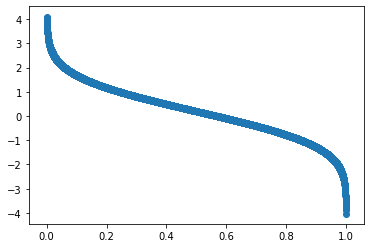

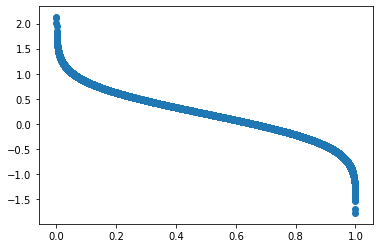

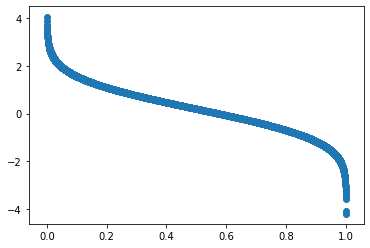

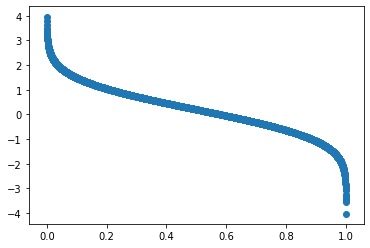

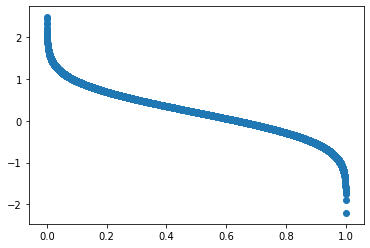

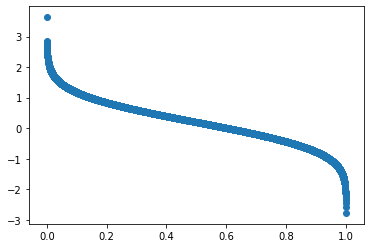

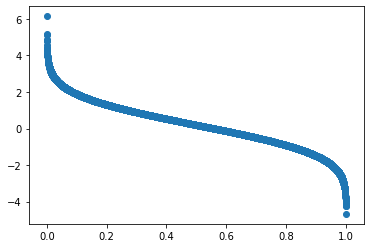

In [55]:
### Compute and plot the MTE for each error configuration
compute_MTE(10000, β, cov_f(conf1))
compute_MTE(10000, β, cov_f(conf2))
compute_MTE(10000, β, cov_f(conf3))
compute_MTE(10000, β, cov_f(conf4))
compute_MTE(10000, β, cov_f(conf5))
compute_MTE(10000, β, cov_f(conf6))
compute_MTE(10000, β, cov_f(conf7))

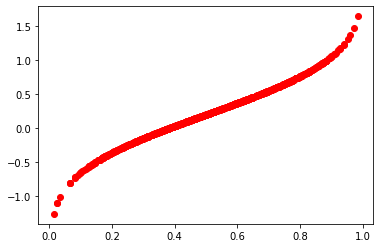

In [9]:
# Obtain data for MTE with config 1 to work onward
Y1, Y0, Z, C, D, cov, μD, Ud, MTE, U1, U0, UC = compute_MTE(N, α, β, minmax_baseline[0], minmax_baseline[1], mean, conf1, return_v=True)


## LIV
What Economic Question Can LATE Answer? S 15

$\frac{\partial E(Y | P(Z) = p}{\partial p} = E(Y_1 - Y_0 | U_d = p) = \frac{\partial S(p)}{\partial p}$

$\frac{\partial E(Y | P(Z) = p}{\partial p} = \beta + E(U_1 - U_0 | U_d = p)$

### What is the difference between MTE and LIV?

In [10]:
# B. LIV?

# Chase - I need to look through above code more closely, but my guess is that he wants us to 
# manually compute LIV here. Of course, MTE = LIV in population, and my guess is this question is getting
# at that point.

In [11]:
# C. Compute objective and subjective Treatment effects
# Building bridges paper: 
# ex post objective outcome = Y0, Y1 ; ex ante subjective outcomes = E(Y0|I), E(Y1|I)
def treat_effect_f(Y1, Y0, C, U1, U0, UC):
    obj = β + Z
    subj = Y1 - Y0 - C     #eq: β + Z + U1 - U0 - UC
    return(obj, subj)

In [12]:
obj, subj = treat_effect_f(Y1, Y0, C, U1, U0, UC)

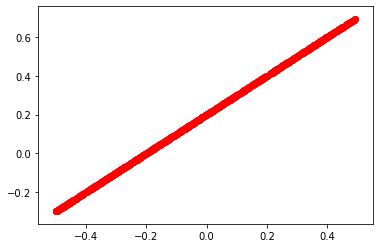

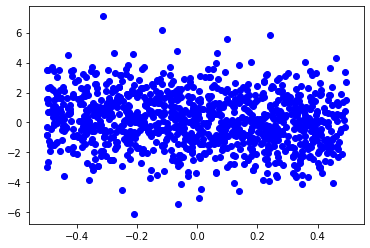

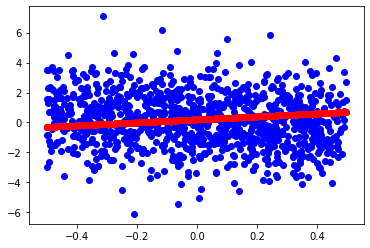

In [13]:
plt.scatter(Z, obj, c="red")
plt.show()
plt.scatter(Z, subj, c="blue")
plt.show()
plt.scatter(Z, subj, c="blue")
plt.scatter(Z, obj, c="red")
plt.show()

In [ ]:
# D.Derive the weights on it to obtain the following treatment parameters 
#- ATE, TOT, TUT, the linear IV weight, the OLS weight, and the PRTE weight.

ATE (here we don't have an x)

$\omega_{ATE}(x, U_D) = 1$

TT (here we don't have an x) see slides 13 and 10 of MTE as generator

$\omega_{TT}(x, U_D) = [\int_{U_D}^{1} f_{P|X}(p | X=x) dp] \frac{1}{E(P|X=x)} = \frac{1 - F_{P|x}(U_D|x)}{E(P(Z)|X=x)}$

Where $U_D = Pr(D(Z) = 1) = P(z)$

In [ ]:
# Need to sort everything again according to Ud
arr1inds = Ud.argsort()
UD_sorted = Ud[arr1inds[::1]]
Z_sorted = Z[arr1inds[::1]]
MTE_sorted = MTE[arr1inds[::1]]




In [ ]:
# Below is rather an experiment than anything else for now...
def weight_ATE_f(N, UD_sorted):
    return(np.ones(N))

def weight_TT_f(N, UD_sorted):
    # E(P) = share of treated
    E_P = sum(D)/len(D)
    # cd slide13, MTE as Generator
    CDF_Ud = (UD_sorted - np.min(UD_sorted)) / (np.max(UD_sorted) - np.min(UD_sorted))
    S_P = 1 - CDF_Ud
    weight_TT = S_P / E_P
    return(weight_TT)




# It should integrate to 1...
weight_TT_int = simps(weight_TT_f(len(UD_sorted), UD_sorted), UD_sorted)
weight_ATE_int = simps(weight_ATE_f(len(UD_sorted), UD_sorted), UD_sorted)
print("Sum weights TT", simps(weight_TT_f(len(UD_sorted), UD_sorted), UD_sorted)) # takes the integral of the weights on Ud
print("Sum weights ATE", simps(weight_ATE_f(len(UD_sorted), UD_sorted), UD_sorted))

weight_TT = weight_TT_f(len(UD_sorted), UD_sorted)
weight_ATE = weight_ATE_f(len(UD_sorted), UD_sorted)

In [ ]:
TT_inside = MTE_sorted * weight_TT
TT = simps(TT_inside, UD_sorted) #Takes the integral of MTE*weight_TT on Ud
print("TT ", TT)
plt.scatter(UD_sorted, TT_inside)

In [ ]:
plt.scatter(UD_sorted, weight_TT)
plt.scatter(UD_sorted, weight_ATE)

In [ ]:
ATE_inside = MTE_sorted * weight_ATE
ATE = simps(ATE_inside, UD_sorted) #Takes the integral of MTE*weight_TT on Ud
print("ATE ", ATE)

plt.scatter(UD_sorted, ATE_inside)
plt.scatter(UD_sorted, TT_inside)

In [ ]:
# E. Which estimators and parameters depend on normality? Show how to relax it.